## Installing Dependencies

In [1]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
# !pip list

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try :
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
     pass

## 1. Build Data Loading Functions:

In [6]:
import gdown

In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=f5a6c4e6-b59e-4bdb-8027-12b44a923d1b
To: c:\Users\Admin\Lip_Reading_project\data.zip
  7%|▋         | 28.8M/423M [00:04<00:56, 6.94MB/s]

KeyboardInterrupt: 

  7%|▋         | 29.4M/423M [00:20<00:56, 6.94MB/s]

In [13]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    # #file_name = path.split('/')[-1].split('.')[0]
    # # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    file_name = os.path.splitext(os.path.basename(path))[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    # print(video_path)
    # print(alignment_path)
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [14]:
# def load_data(path: str): 
#     path = bytes.decode(path.numpy())
#     #file_name = path.split('/')[-1].split('.')[0]
#     # File name splitting for windows
#     file_name = path.split('\\')[-1].split('.')[0]
#     video_path = os.path.join('data','s1',f'{file_name}.mpg')
#     alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
#     frames = load_video(video_path) 
#     alignments = load_alignments(alignment_path)
    
#     return frames, alignments

In [15]:
test_path = r'data\s1\bbaf5a.mpg'

In [16]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'data\\s1\\bbaf5a.mpg'>

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [18]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbaf5a'

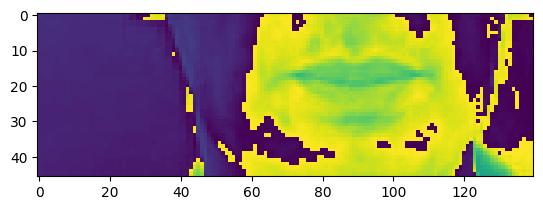

In [19]:
plt.imshow(frames[20])

In [20]:
alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39,  6,  9, 22,
        5, 39,  1,  7,  1,  9, 14], dtype=int64)>

In [21]:
tf.strings.reduce_join([num_to_char(x).numpy().decode('utf-8') for x in alignments.numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f five again'>

In [22]:
# Alternate way to do the same thing as the above cell:
# tf.strings.reduce_join([x.decode('utf-8') for x in num_to_char(alignments.numpy()).numpy()])

In [23]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [24]:
# mappable_function(r'data\\s1\\bbaf5a.mpg')
mappable_function(test_path)

[<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[1.368547  ],
          [1.368547  ],
          [1.368547  ],
          ...,
          [8.93357   ],
          [9.427768  ],
          [9.617844  ]],
 
         [[1.368547  ],
          [1.368547  ],
          [1.368547  ],
          ...,
          [9.123646  ],
          [9.503798  ],
          [9.503798  ]],
 
         [[1.2545013 ],
          [1.2545013 ],
          [1.2164861 ],
          ...,
          [0.07603038],
          [0.11404558],
          [0.11404558]],
 
         ...,
 
         [[0.9123646 ],
          [0.9123646 ],
          [0.8743494 ],
          ...,
          [9.503798  ],
          [9.617844  ],
          [9.617844  ]],
 
         [[0.9123646 ],
          [0.9123646 ],
          [0.8743494 ],
          ...,
          [9.1996765 ],
          [9.389752  ],
          [9.541813  ]],
 
         [[0.9123646 ],
          [0.9123646 ],
          [0.8743494 ],
          ...,
          [9.237692  ],
    

## 2. Create Data Pipeline:

In [25]:
data = tf.data.Dataset.list_files('data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration= False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [26]:
data.as_numpy_iterator().next()

(array([[[[[1.4336008 ],
           [1.4336008 ],
           [1.3561089 ],
           ...,
           [9.337778  ],
           [9.492762  ],
           [9.144049  ]],
 
          [[1.4336008 ],
           [1.4336008 ],
           [1.3561089 ],
           ...,
           [8.524113  ],
           [8.950318  ],
           [9.066556  ]],
 
          [[1.3173629 ],
           [1.3173629 ],
           [1.3173629 ],
           ...,
           [9.686492  ],
           [9.763984  ],
           [9.763984  ]],
 
          ...,
 
          [[0.9686492 ],
           [0.9299032 ],
           [0.9299032 ],
           ...,
           [9.763984  ],
           [9.763984  ],
           [9.763984  ]],
 
          [[0.9299032 ],
           [0.9299032 ],
           [0.9299032 ],
           ...,
           [9.686492  ],
           [9.647746  ],
           [9.647746  ]],
 
          [[0.9299032 ],
           [0.9299032 ],
           [0.9299032 ],
           ...,
           [9.686492  ],
           [9.647746  

In [27]:
alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39,  6,  9, 22,
        5, 39,  1,  7,  1,  9, 14], dtype=int64)>

In [28]:
frames, alignments = data.as_numpy_iterator().next()

In [29]:
test = data.as_numpy_iterator()

In [30]:
val = test.next()


In [31]:
val[1][0]

array([12,  1, 25, 39,  7, 18,  5,  5, 14, 39,  1, 20, 39,  6, 39,  6,  9,
       22,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int64)

In [32]:
imageio.mimsave('.\\animation.gif', val[0][1], fps = 10)

TypeError: Cannot handle this data type: (1, 1, 1), <f4

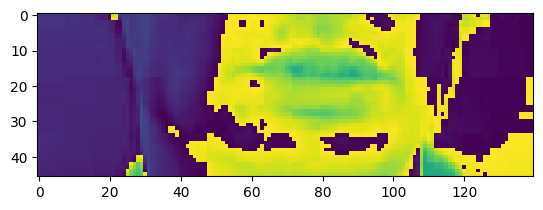

In [ ]:
plt.imshow(val[0][0][0])

In [ ]:
val_uint8 = (val[0][1] * 60).astype(np.uint8) 
if val_uint8.shape[-1] == 1:  # If single channel, convert to RGB
    val_uint8 = np.repeat(val_uint8, 3, axis=-1)  # Repeat grayscale across 3 channels
elif val_uint8.shape[-1] != 3:
    raise ValueError("Unexpected number of image channels. Expected 1 or 3.")

imageio.mimsave('./animation.gif', val_uint8, fps=10)

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green at h one soon'>

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green at h one soon'>

## 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape = (75, 46, 140, 1), padding = 'same', activation= 'relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding = 'same', activation= 'relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding = 'same', activation= 'relu'))
model.add(MaxPool3D((1,2,2)))

# model.add(TimeDistributed(Flatten()))
model.add(Reshape((-1, np.prod(model.output_shape[2:]))))

model.add(Bidirectional(LSTM(128, kernel_initializer= 'Orthogonal', return_sequences= True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer= 'Orthogonal', return_sequences= True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_19 (Conv3D)              │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_20 (Conv3D)              │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_21 (Conv3D)              │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]]).numpy()

b'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj'

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]).numpy()

b'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj'

In [ ]:
print(yhat.shape[0])
print(yhat[0].shape)
print(yhat[1].shape)

2
(75, 41)
(75, 41)


In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

## 4. Setup Training Options and Train:

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(data)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
186/450 ━━━━━━━━━━━━━━━━━━━━ 3:57:17 54s/step - loss: 116.3870

KeyboardInterrupt: 

In [ ]:
print("hello")

hello
